In [7]:
import pandas as pd


sentiment_path = "/content/fear_greed_index.csv"
sentiment_df = pd.read_csv(sentiment_path)


print("Shape:", sentiment_df.shape)
sentiment_df.head(10)


Shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05
5,1517895000,8,Extreme Fear,2018-02-06
6,1517981400,36,Fear,2018-02-07
7,1518067800,30,Fear,2018-02-08
8,1518154200,44,Fear,2018-02-09
9,1518240600,54,Neutral,2018-02-10


**Clean the Sentiment Dataset**

In [8]:
# Standardize column names
sentiment_df.columns = sentiment_df.columns.str.lower().str.strip()

# Convert date to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Remove duplicates
sentiment_df.drop_duplicates(inplace=True)

sentiment_df.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


**Check the Sentiment Distribution**

In [9]:
sentiment_df['classification'].value_counts()


,count
classification,
Fear,781
Greed,633
Extreme Fear,508
Neutral,396
Extreme Greed,326


**Feature Engineering**

In [10]:

# Make a working copy
df = sentiment_df.copy()

# Ensure DATE column is in datetime format
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# 4.1 Create numeric sentiment score
sentiment_map = {
    "Extreme Fear": -2,
    "Fear": -1,
    "Neutral": 0,
    "Greed": 1,
    "Extreme Greed": 2
}

df["sentiment_score"] = df["classification"].map(sentiment_map)

# 4.2 Create date-related features
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["week"] = df["date"].dt.isocalendar().week
df["day_of_week"] = df["date"].dt.day_name()

# 4.3 Weekend flag
df["is_weekend"] = df["day_of_week"].isin(["Saturday", "Sunday"])

# 4.4 Broad grouping (Fear → Negative, Greed → Positive)
def get_group(x):
    if x in ["Extreme Fear", "Fear"]:
        return "Negative Sentiment"
    elif x in ["Greed", "Extreme Greed"]:
        return "Positive Sentiment"
    return "Neutral Sentiment"

df["sentiment_group"] = df["classification"].apply(get_group)

# Preview final engineered dataset
df.head(10)

,timestamp,value,classification,date,sentiment_score,year,month,week,day_of_week,is_weekend,sentiment_group
0,1517463000,30,Fear,2018-02-01,-1,2018,2,5,Thursday,False,Negative Sentiment
1,1517549400,15,Extreme Fear,2018-02-02,-2,2018,2,5,Friday,False,Negative Sentiment
2,1517635800,40,Fear,2018-02-03,-1,2018,2,5,Saturday,True,Negative Sentiment
3,1517722200,24,Extreme Fear,2018-02-04,-2,2018,2,5,Sunday,True,Negative Sentiment
4,1517808600,11,Extreme Fear,2018-02-05,-2,2018,2,6,Monday,False,Negative Sentiment
5,1517895000,8,Extreme Fear,2018-02-06,-2,2018,2,6,Tuesday,False,Negative Sentiment
6,1517981400,36,Fear,2018-02-07,-1,2018,2,6,Wednesday,False,Negative Sentiment
7,1518067800,30,Fear,2018-02-08,-1,2018,2,6,Thursday,False,Negative Sentiment
8,1518154200,44,Fear,2018-02-09,-1,2018,2,6,Friday,False,Negative Sentiment
9,1518240600,54,Neutral,2018-02-10,0,2018,2,6,Saturday,True,Neutral Sentiment


**Sentiment Aggregations**

In [11]:
daily_sentiment = df.groupby("date")[["value", "sentiment_score"]].mean()
daily_sentiment.head()


,value,sentiment_score
date,,
2018-02-01,30.0,-1.0
2018-02-02,15.0,-2.0
2018-02-03,40.0,-1.0
2018-02-04,24.0,-2.0
2018-02-05,11.0,-2.0


**Weekly sentiment trend**

In [12]:
weekly_sentiment = df.groupby("week")["sentiment_score"].mean()
weekly_sentiment.head()


,sentiment_score
week,
1,-0.122449
2,-0.040816
3,0.061224
4,0.102041
5,0.207547


**Monthly sentiment trend**

In [13]:
monthly_sentiment = df.groupby(["year", "month"])["sentiment_score"].mean()
monthly_sentiment.head()


year  month
2018  2       -0.571429
      3       -0.935484
      4       -1.148148
      5       -0.548387
      6       -1.533333
Name: sentiment_score, dtype: float64

**Yearly sentiment trend**

In [14]:
yearly_sentiment = df.groupby("year")["sentiment_score"].mean()
yearly_sentiment


,sentiment_score
year,
2018,-1.181269
2019,-0.334247
2020,0.073770
2021,0.252055
2022,-1.446575
2023,0.323288
2024,0.827397
2025,-0.081967


**Count of each sentiment group**

In [15]:
sentiment_group_dist = df["sentiment_group"].value_counts()
sentiment_group_dist


,count
sentiment_group,
Negative Sentiment,1289
Positive Sentiment,959
Neutral Sentiment,396


In [16]:
df["sentiment_7d"] = df["sentiment_score"].rolling(7).mean()
df["sentiment_30d"] = df["sentiment_score"].rolling(30).mean()
df["sentiment_90d"] = df["sentiment_score"].rolling(90).mean()
df[["date", "sentiment_score", "sentiment_7d", "sentiment_30d"]].head(20)


,date,sentiment_score,sentiment_7d,sentiment_30d
0,2018-02-01,-1,NaN,NaN
1,2018-02-02,-2,NaN,NaN
2,2018-02-03,-1,NaN,NaN
3,2018-02-04,-2,NaN,NaN
4,2018-02-05,-2,NaN,NaN
5,2018-02-06,-2,NaN,NaN
6,2018-02-07,-1,-1.571429,NaN
7,2018-02-08,-1,-1.571429,NaN
8,2018-02-09,-1,-1.428571,NaN
9,2018-02-10,0,-1.285714,NaN


In [17]:
import numpy as np
df["sentiment_peak"] = np.where(
    (df["sentiment_score"] > df["sentiment_score"].shift(1)) &
    (df["sentiment_score"] > df["sentiment_score"].shift(-1)),
    1, 0
)

df["sentiment_trough"] = np.where(
    (df["sentiment_score"] < df["sentiment_score"].shift(1)) &
    (df["sentiment_score"] < df["sentiment_score"].shift(-1)),
    1, 0
)

df[["date", "sentiment_score", "sentiment_peak", "sentiment_trough"]].head(20)


,date,sentiment_score,sentiment_peak,sentiment_trough
0,2018-02-01,-1,0,0
1,2018-02-02,-2,0,1
2,2018-02-03,-1,1,0
3,2018-02-04,-2,0,0
4,2018-02-05,-2,0,0
5,2018-02-06,-2,0,0
6,2018-02-07,-1,0,0
7,2018-02-08,-1,0,0
8,2018-02-09,-1,0,0
9,2018-02-10,0,1,0


**Streaks of fear & greed**

In [18]:
df["fear"] = df["classification"].isin(["Fear", "Extreme Fear"]).astype(int)
df["greed"] = df["classification"].isin(["Greed", "Extreme Greed"]).astype(int)

df["fear_streak"] = df["fear"] * (df["fear"].groupby((df["fear"] != df["fear"].shift()).cumsum()).cumcount() + 1)
df["greed_streak"] = df["greed"] * (df["greed"].groupby((df["greed"] != df["greed"].shift()).cumsum()).cumcount() + 1)

df[["date", "fear_streak", "greed_streak"]].head(30)


,date,fear_streak,greed_streak
0,2018-02-01,1,0
1,2018-02-02,2,0
2,2018-02-03,3,0
3,2018-02-04,4,0
4,2018-02-05,5,0
5,2018-02-06,6,0
6,2018-02-07,7,0
7,2018-02-08,8,0
8,2018-02-09,9,0
9,2018-02-10,0,0


In [19]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn
!pip install ydata-profiling
!pip install jupyterlab
!pip install openpyxl
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.7 MB/s eta 0:00:00


In [20]:
import pandas as pd

# Load dataset
df = pd.read_csv("historical_data.csv", low_memory=False)

# ---- Clean Column Names ----
df.columns = (
    df.columns.str.lower()
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

# ---- Convert timestamps ----
df['timestamp_ist'] = pd.to_datetime(df['timestamp_ist'], errors='coerce')

# ---- Quick diagnostics ----
print("Shape:", df.shape)
print("\nMissing values:")
print(df.isna().sum())

print("\nData Types:")
print(df.dtypes)

df.head(10)


Shape: (144616, 16)

Missing values:
account                 0
coin                    1
execution_price         1
size_tokens             1
size_usd                1
side                    1
timestamp_ist       89838
start_position          1
direction               1
closed_pnl              1
transaction_hash        1
order_id                1
crossed                 1
fee                     1
trade_id                1
timestamp               1
dtype: int64

Data Types:
account                     object
coin                        object
execution_price            float64
size_tokens                float64
size_usd                   float64
side                        object
timestamp_ist       datetime64[ns]
start_position             float64
direction                   object
closed_pnl                 float64
transaction_hash            object
order_id                   float64
crossed                     object
fee                        float64
trade_id                   floa

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9900,1.41,11.27,BUY,2024-02-12 22:50:00,1298.215466,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.000493,7.330000e+14,1.730000e+12
6,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9934,144.09,1151.77,BUY,2024-02-12 22:50:00,1299.624972,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,9.060000e+14,1.730000e+12
7,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,34.00,272.00,BUY,2024-02-12 22:50:00,1443.664541,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.011900,3.960000e+14,1.730000e+12
8,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,46.00,368.00,BUY,2024-02-12 22:50:00,1477.652641,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.016100,9.460000e+14,1.730000e+12
9,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,12.50,100.00,BUY,2024-02-12 22:50:00,1523.636541,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.004375,3.470000e+13,1.730000e+12


In [21]:

import numpy as np

# Step 2.1 → Remove rows with single missing values
df = df.dropna(subset=["closed_pnl", "transaction_hash", "order_id", "crossed", "fee", "trade_id", "timestamp"])

# Step 2.2 → Handle timestamps
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", errors="coerce")

# Convert missing IST timestamps
df["timestamp_ist"] = df["timestamp"].dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")

# Step 2.3 → Feature engineering
df["trade_value"] = df["execution_price"] * df["size_tokens"]
df["profit_flag"] = (df["closed_pnl"] > 0).astype(int)
df["trade_hour"] = df["timestamp_ist"].dt.hour
df["trade_day"] = df["timestamp_ist"].dt.day_name()

# Step 2.4 → Standardize categories
df["side"] = df["side"].str.lower().str.strip()
df["direction"] = df["direction"].str.lower().str.strip()
df["crossed"] = df["crossed"].astype(str).str.lower()

# Step 2.5 → Save cleaned file
df.to_csv("cleaned_data.csv", index=False)

df.head()


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,trade_value,profit_flag,trade_hour,trade_day
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,2024-10-27 09:03:20+05:30,0.000000,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,true,0.345404,8.950000e+14,2024-10-27 03:33:20,7872.163303,0,9,Sunday
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,2024-10-27 09:03:20+05:30,986.524596,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,true,0.005600,4.430000e+14,2024-10-27 03:33:20,127.680000,0,9,Sunday
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,2024-10-27 09:03:20+05:30,1002.518996,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,true,0.050431,6.600000e+14,2024-10-27 03:33:20,1150.630695,0,9,Sunday
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,2024-10-27 09:03:20+05:30,1146.558564,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,true,0.050043,1.080000e+15,2024-10-27 03:33:20,1142.038452,0,9,Sunday
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,2024-10-27 09:03:20+05:30,1289.488521,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,true,0.003055,1.050000e+15,2024-10-27 03:33:20,69.747462,0,9,Sunday


In [22]:

import seaborn as sns
import matplotlib.pyplot as plt

# 3A. Basic EDA
print("Shape:", df.shape)

print("\nSummary Statistics:")
display(df.describe(include='all'))

print("\nUnique Values in Categorical Columns:")
for col in ["side", "direction", "crossed", "coin", "trade_day"]:
    print(f"{col}: {df[col].nunique()} unique values → {df[col].unique()[:10]}")


Shape: (144615, 20)

Summary Statistics:


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,trade_value,profit_flag,trade_hour,trade_day
count,144615,144615,144615.000000,1.446150e+05,1.446150e+05,144615,144615,1.446150e+05,144615,144615.000000,144615,1.446150e+05,144615,144615.000000,1.446150e+05,144615,1.446150e+05,144615.000000,144615.000000,144615
unique,22,238,NaN,NaN,NaN,2,NaN,NaN,12,NaN,81071,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,5
top,0xbaaaf6571ab7d571043ff1e313a9609a10637864,HYPE,NaN,NaN,NaN,buy,NaN,NaN,open long,NaN,0x00000000000000000000000000000000000000000000...,NaN,true,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
freq,21192,41965,NaN,NaN,NaN,72680,NaN,NaN,37748,NaN,5036,NaN,82236,NaN,NaN,NaN,NaN,NaN,NaN,87173
mean,NaN,NaN,14348.998678,5.862646e+03,5.996890e+03,NaN,2025-01-17 02:12:05.159907328+05:30,-5.593322e+04,NaN,54.311162,NaN,6.724839e+10,NaN,1.195446,5.624865e+14,2025-01-16 20:42:05.159907328,5.996890e+03,0.407800,7.096359,NaN
min,NaN,NaN,0.000005,8.740000e-07,0.000000e+00,NaN,2023-03-28 16:10:00+05:30,-1.433463e+07,NaN,-117990.104100,NaN,1.732711e+08,NaN,-1.175712,0.000000e+00,2023-03-28 10:40:00,1.627190e-07,0.000000,2.000000,NaN
25%,NaN,NaN,2.500000,1.800000e+00,1.598300e+02,NaN,2024-10-27 09:03:20+05:30,-4.177250e+02,NaN,0.000000,NaN,5.722777e+10,NaN,0.014220,2.800000e+14,2024-10-27 03:33:20,1.598290e+02,0.000000,2.000000,NaN
50%,NaN,NaN,18.320000,3.000000e+01,5.548300e+02,NaN,2025-02-20 02:50:00+05:30,2.248530e+01,NaN,0.000000,NaN,7.297273e+10,NaN,0.075430,5.620000e+14,2025-02-19 21:20:00,5.548310e+02,0.000000,2.000000,NaN
75%,NaN,NaN,211.000000,2.133400e+02,2.000100e+03,NaN,2025-02-20 02:50:00+05:30,5.797911e+03,NaN,5.771318,NaN,8.239360e+10,NaN,0.349778,8.460000e+14,2025-02-19 21:20:00,2.000102e+03,1.000000,9.000000,NaN
max,NaN,NaN,109004.000000,1.582244e+07,3.921431e+06,NaN,2025-06-15 20:36:40+05:30,3.050948e+07,NaN,135329.090100,NaN,9.014923e+10,NaN,837.471593,1.130000e+15,2025-06-15 15:06:40,3.921431e+06,1.000000,21.000000,NaN



Unique Values in Categorical Columns:
side: 2 unique values → ['buy' 'sell']
direction: 12 unique values → ['buy' 'sell' 'open long' 'close long' 'spot dust conversion' 'open short'
 'close short' 'long > short' 'short > long' 'auto-deleveraging']
crossed: 2 unique values → ['true' 'false']
coin: 238 unique values → ['@107' 'AAVE' 'DYDX' 'AIXBT' 'GMX' 'EIGEN' 'HYPE' 'SOL' 'SUI' 'DOGE']
trade_day: 5 unique values → ['Sunday' 'Thursday' 'Saturday' 'Wednesday' 'Tuesday']


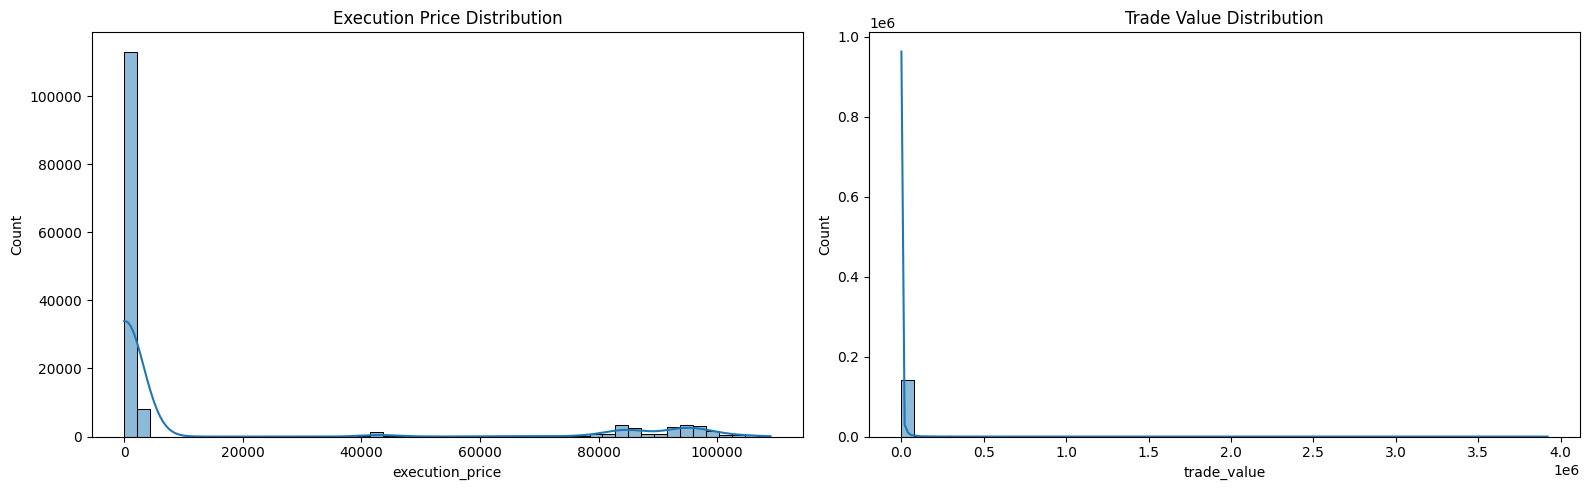

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
sns.histplot(df['execution_price'], bins=50, kde=True)
plt.title("Execution Price Distribution")

plt.subplot(1,2,2)
sns.histplot(df['trade_value'], bins=50, kde=True)
plt.title("Trade Value Distribution")

plt.tight_layout()
plt.show()


/tmp/ipython-input-2801524989.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='profit_flag', palette='coolwarm')


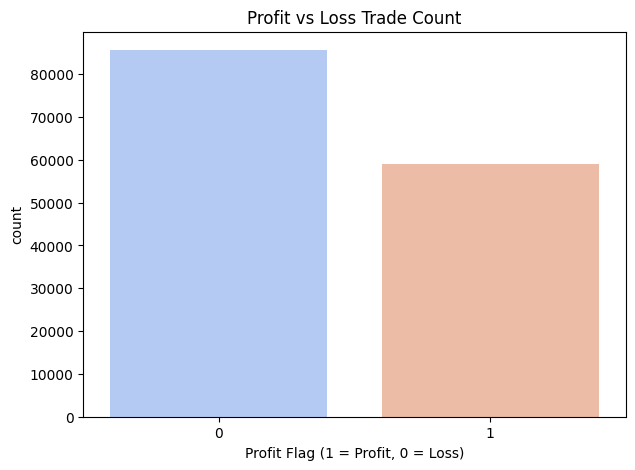

In [24]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='profit_flag', palette='coolwarm')
plt.title("Profit vs Loss Trade Count")
plt.xlabel("Profit Flag (1 = Profit, 0 = Loss)")
plt.show()


/tmp/ipython-input-2320106274.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='trade_hour', palette='viridis')


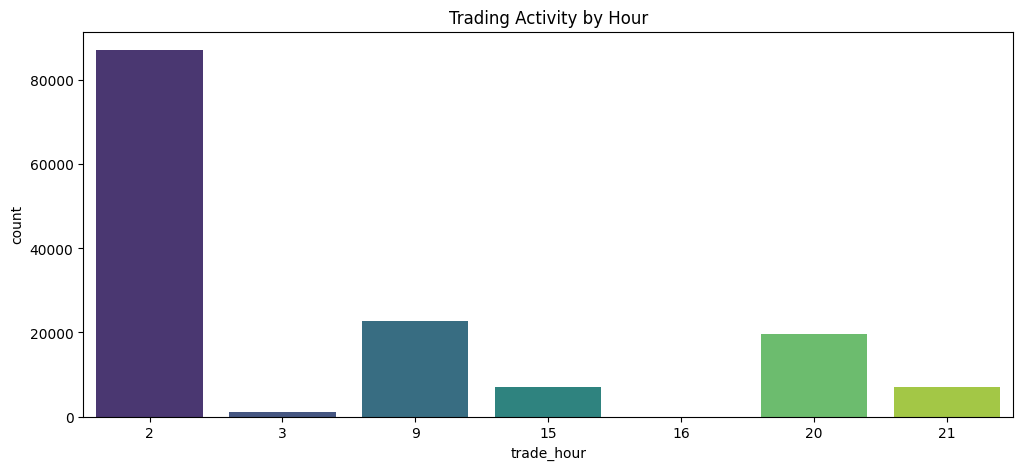

In [25]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='trade_hour', palette='viridis')
plt.title("Trading Activity by Hour")
plt.show()


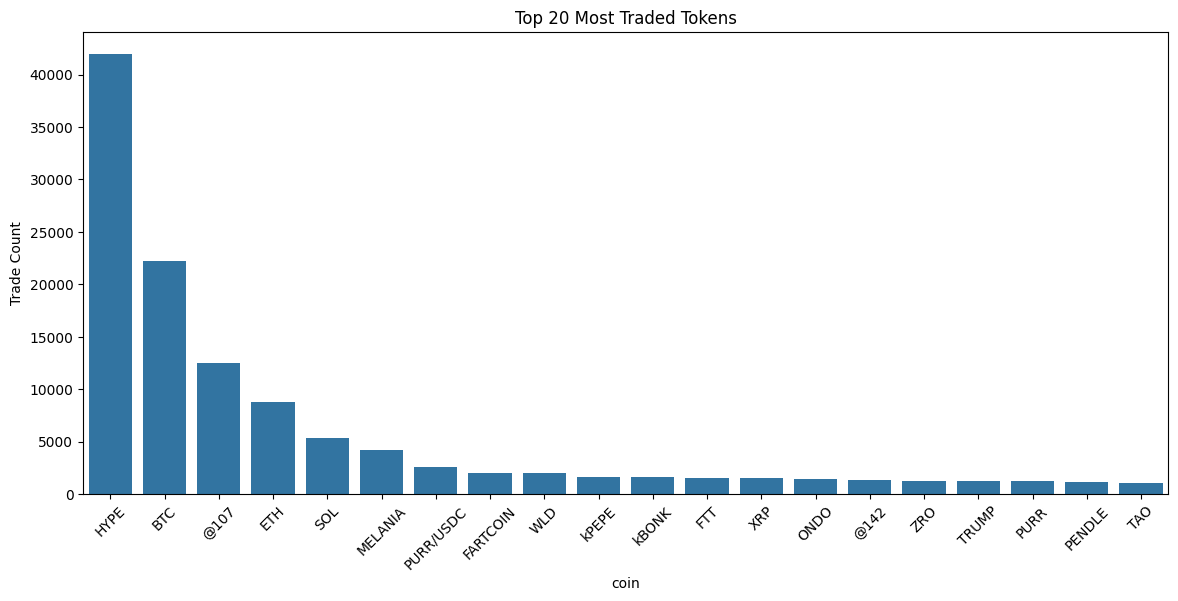

In [26]:
plt.figure(figsize=(14,6))
top_coins = df['coin'].value_counts().head(20)

sns.barplot(x=top_coins.index, y=top_coins.values)
plt.xticks(rotation=45)
plt.title("Top 20 Most Traded Tokens")
plt.ylabel("Trade Count")
plt.show()


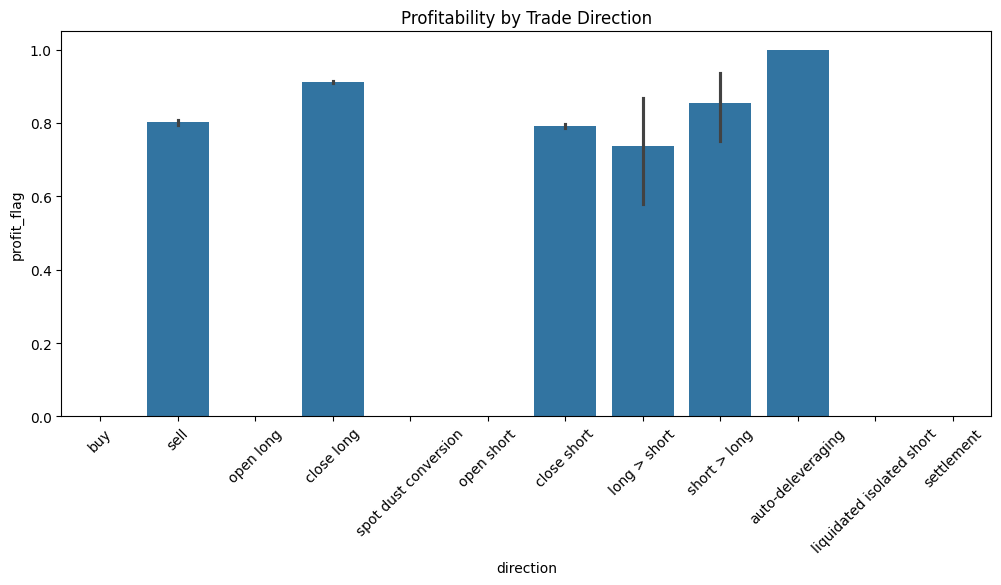

In [27]:
plt.figure(figsize=(12,5))
sns.barplot(data=df, x='direction', y='profit_flag')
plt.xticks(rotation=45)
plt.title("Profitability by Trade Direction")
plt.show()


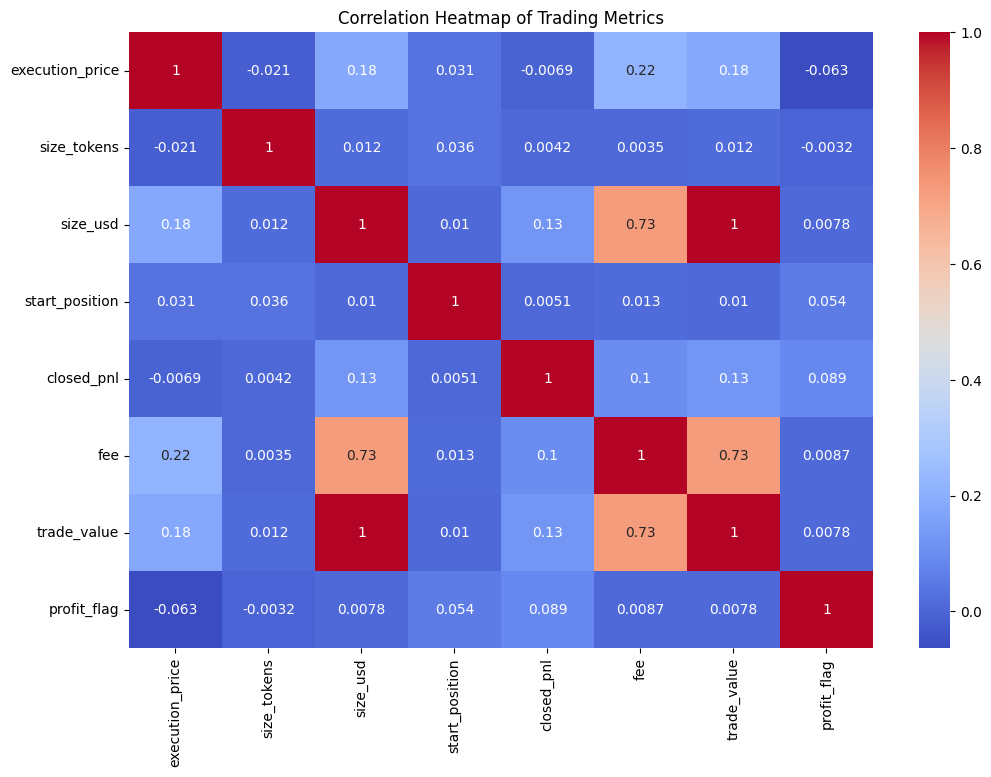

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(df[['execution_price','size_tokens','size_usd','start_position',
                'closed_pnl','fee','trade_value','profit_flag']].corr(),
            annot=True, cmap='coolwarm')

plt.title("Correlation Heatmap of Trading Metrics")
plt.show()


In [29]:

df = pd.read_csv("cleaned_data.csv")
df.head()


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,trade_value,profit_flag,trade_hour,trade_day
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,2024-10-27 09:03:20+05:30,0.000000,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,2024-10-27 03:33:20,7872.163303,0,9,Sunday
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,2024-10-27 09:03:20+05:30,986.524596,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,2024-10-27 03:33:20,127.680000,0,9,Sunday
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,2024-10-27 09:03:20+05:30,1002.518996,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,2024-10-27 03:33:20,1150.630695,0,9,Sunday
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,2024-10-27 09:03:20+05:30,1146.558564,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,2024-10-27 03:33:20,1142.038452,0,9,Sunday
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,2024-10-27 09:03:20+05:30,1289.488521,buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,2024-10-27 03:33:20,69.747462,0,9,Sunday


In [30]:

# 1. Convert timestamp_ist to datetime
df['timestamp_ist'] = pd.to_datetime(df['timestamp_ist'], errors='coerce')

# 2. Create a DATE column
df['date'] = df['timestamp_ist'].dt.date

# 3. Get the date range of trades
min_date = df['date'].min()
max_date = df['date'].max()

print("Date Range in Dataset:")
print("Start Date:", min_date)
print("End Date:", max_date)

# 4. Count trades per day
trade_counts = df['date'].value_counts().sort_index()

print("\nTrades Per Day:")
print(trade_counts.head(10))


Date Range in Dataset:
Start Date: 2023-03-28
End Date: 2025-06-15

Trades Per Day:
date
2023-03-28        3
2023-11-15     1045
2024-03-09     6962
2024-07-03     7097
2024-10-27    22786
2025-02-20    87173
2025-06-15    19549
Name: count, dtype: int64


Daily Trade Summary:
count        7.000000
mean     20659.285714
std      30585.354364
min          3.000000
25%       4003.500000
50%       7097.000000
75%      21167.500000
max      87173.000000
Name: count, dtype: float64


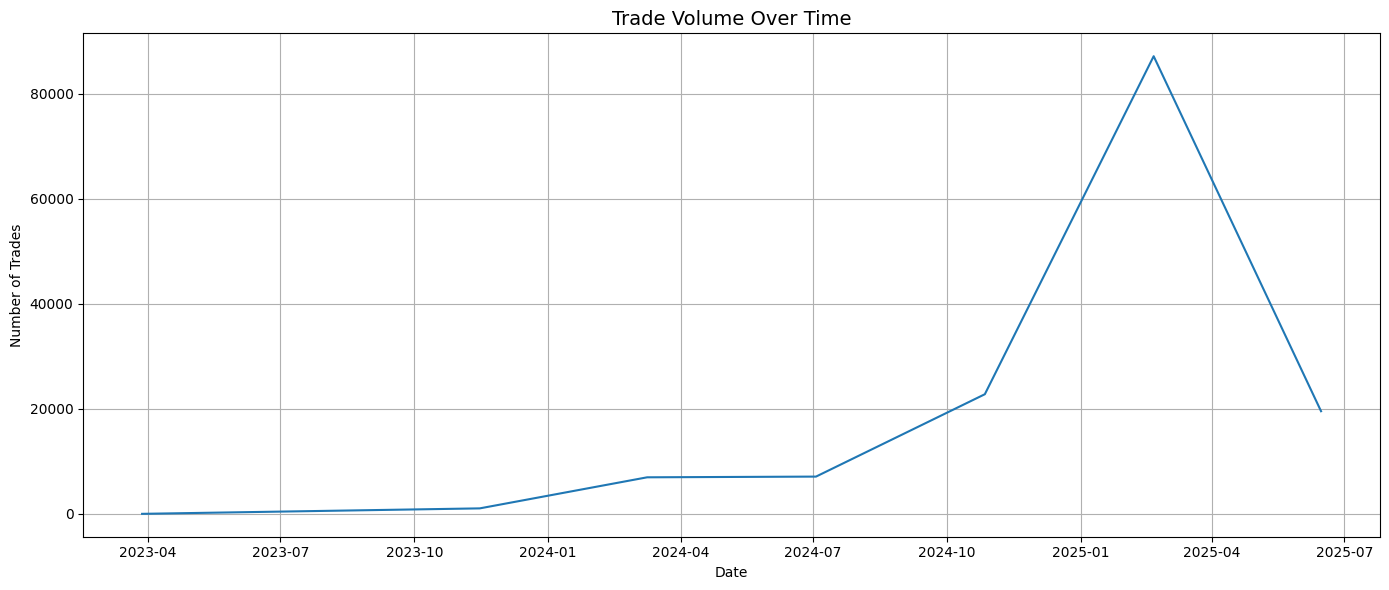


Top 10 Highest Volume Days:
date
2025-02-20    87173
2024-10-27    22786
2025-06-15    19549
2024-07-03     7097
2024-03-09     6962
2023-11-15     1045
2023-03-28        3
Name: count, dtype: int64

Lowest 10 Volume Days:
date
2023-03-28        3
2023-11-15     1045
2024-03-09     6962
2024-07-03     7097
2025-06-15    19549
2024-10-27    22786
2025-02-20    87173
Name: count, dtype: int64


In [31]:
#STEP 4.3: Time-Series Trade Volume Analysis ---

# 1. Compute trades per day
daily_trades = df['date'].value_counts().sort_index()

print("Daily Trade Summary:")
print(daily_trades.describe())

# 2. Plot time-series chart
plt.figure(figsize=(14, 6))
plt.plot(daily_trades.index, daily_trades.values)
plt.title("Trade Volume Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Trades")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Identify top 10 highest-volume days
top_days = daily_trades.sort_values(ascending=False).head(10)
print("\nTop 10 Highest Volume Days:")
print(top_days)

# 4. Identify lowest activity days
low_days = daily_trades.sort_values(ascending=True).head(10)
print("\nLowest 10 Volume Days:")
print(low_days)


Trade Side Distribution:
side
buy     72680
sell    71935
Name: count, dtype: int64

Percentage Distribution:
side
buy     50.26
sell    49.74
Name: count, dtype: float64


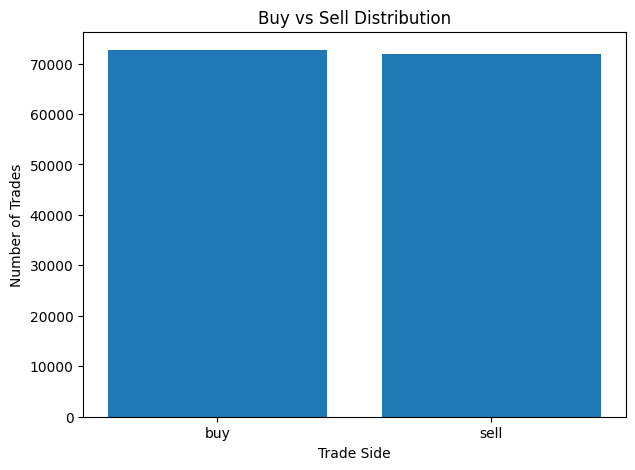

In [32]:
# Count BUY vs SELL trades
side_counts = df['side'].value_counts()

print("Trade Side Distribution:")
print(side_counts)
print("\nPercentage Distribution:")
print((side_counts / len(df) * 100).round(2))

# Plot BUY vs SELL Distribution
plt.figure(figsize=(7,5))
plt.bar(side_counts.index, side_counts.values)
plt.title("Buy vs Sell Distribution")
plt.xlabel("Trade Side")
plt.ylabel("Number of Trades")
plt.show()

Trade Direction Distribution:
direction
open long                    37748
close long                   34670
open short                   28020
close short                  25248
buy                           9634
sell                          9079
spot dust conversion           120
short > long                    48
long > short                    38
auto-deleveraging                8
liquidated isolated short        1
settlement                       1
Name: count, dtype: int64

Percentage Distribution:
direction
open long                    26.10
close long                   23.97
open short                   19.38
close short                  17.46
buy                           6.66
sell                          6.28
spot dust conversion          0.08
short > long                  0.03
long > short                  0.03
auto-deleveraging             0.01
liquidated isolated short     0.00
settlement                    0.00
Name: count, dtype: float64


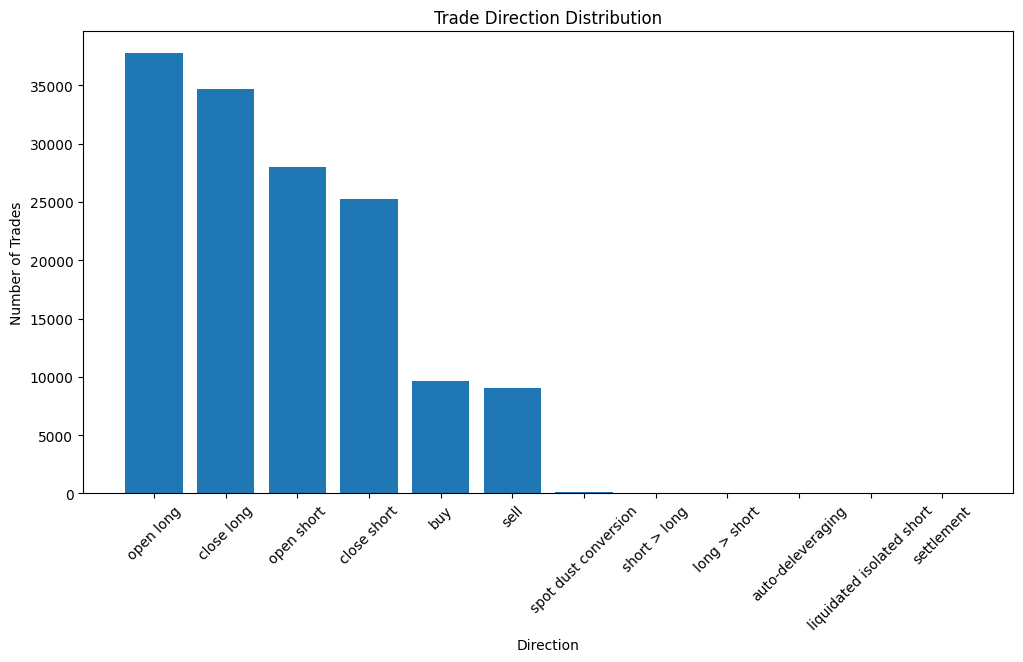

In [33]:

# Count unique directions
direction_counts = df['direction'].value_counts()

print("Trade Direction Distribution:")
print(direction_counts)

print("\nPercentage Distribution:")
print((direction_counts / len(df) * 100).round(2))

# Visualizing direction distribution
plt.figure(figsize=(12,6))
plt.bar(direction_counts.index, direction_counts.values)
plt.title("Trade Direction Distribution")
plt.xlabel("Direction")
plt.ylabel("Number of Trades")
plt.xticks(rotation=45)
plt.show()


In [34]:
# --- STEP 4.6: Profitability Analysis ---

# 1. Basic profit stats
profit_stats = df['closed_pnl'].describe()
print("Profitability Statistics:")
print(profit_stats)

Profitability Statistics:
count    144615.000000
mean         54.311162
std        1029.255907
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.771318
max      135329.090100
Name: closed_pnl, dtype: float64


In [35]:
# 2. Total profit vs total loss
total_profit = df[df['closed_pnl'] > 0]['closed_pnl'].sum()
total_loss = df[df['closed_pnl'] < 0]['closed_pnl'].sum()

In [36]:
print("\nTotal Profit:", total_profit)
print("Total Loss:", total_loss)


Total Profit: 9713698.16296
Total Loss: -1859489.5407980003


In [37]:
# 3. Win rate
win_rate = (df['profit_flag'] == 1).mean() * 100
print("\nWin Rate: {:.2f}%".format(win_rate))


Win Rate: 40.78%


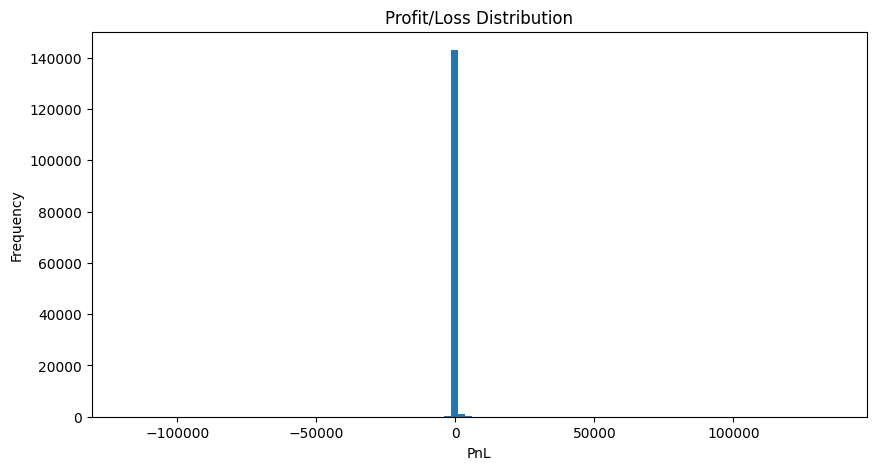

In [38]:
# 4. Profit distribution (Histogram)
plt.figure(figsize=(10,5))
plt.hist(df['closed_pnl'], bins=100)
plt.title("Profit/Loss Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.show()

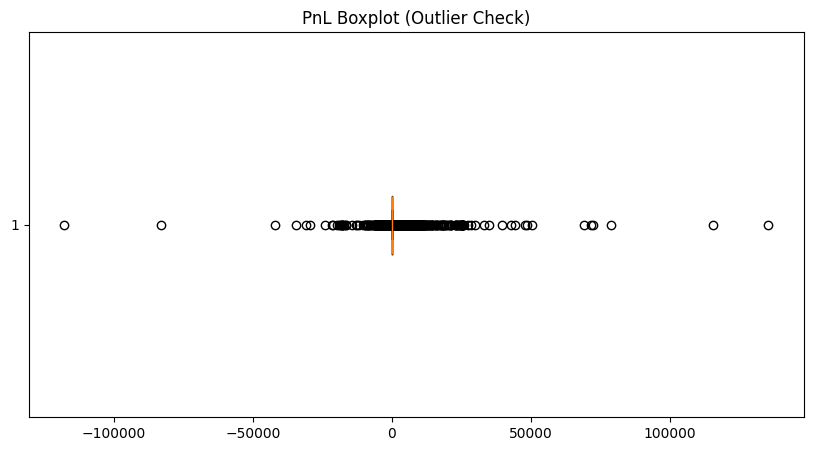

In [39]:
# 5. Boxplot for outlier detection
plt.figure(figsize=(10,5))
plt.boxplot(df['closed_pnl'], vert=False)
plt.title("PnL Boxplot (Outlier Check)")
plt.show()

In [40]:
# 6. Average PnL by direction (key insight)
direction_profit = df.groupby('direction')['closed_pnl'].mean().sort_values(ascending=False)

print("\nAverage Profit by Direction:")
print(direction_profit)


Average Profit by Direction:
direction
auto-deleveraging             7184.807003
sell                           233.529696
close short                    124.039798
long > short                    92.486480
close long                      73.793683
buy                              0.000000
open short                       0.000000
open long                        0.000000
spot dust conversion             0.000000
settlement                     -29.215368
short > long                   -91.710429
liquidated isolated short   -12752.913040
Name: closed_pnl, dtype: float64


In [41]:
# --- STEP 4.7: Volume & Leverage Analysis ---

# 1. Basic stats for size and leverage
print("Trade Size Statistics:")
print(df['size_usd'].describe())

if 'leverage' in df.columns:
    print("\nLeverage Statistics:")
    print(df['leverage'].describe())
else:
    print("\n Leverage column not found, skipping leverage stats.")

Trade Size Statistics:
count    1.446150e+05
mean     5.996890e+03
std      4.179164e+04
min      0.000000e+00
25%      1.598300e+02
50%      5.548300e+02
75%      2.000100e+03
max      3.921431e+06
Name: size_usd, dtype: float64

 Leverage column not found, skipping leverage stats.



Correlation between Trade Size and PnL: 0.1278029789594249


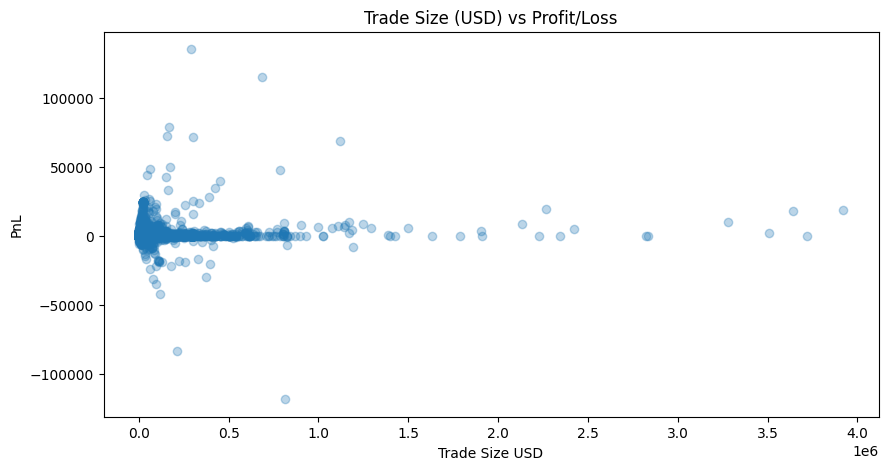

In [42]:
# 2. Correlation between trade size and PnL
corr_size_pnl = df['size_usd'].corr(df['closed_pnl'])
print("\nCorrelation between Trade Size and PnL:", corr_size_pnl)

# 3. Scatter plot: Trade Size vs PnL
plt.figure(figsize=(10,5))
plt.scatter(df['size_usd'], df['closed_pnl'], alpha=0.3)
plt.title("Trade Size (USD) vs Profit/Loss")
plt.xlabel("Trade Size USD")
plt.ylabel("PnL")
plt.show()

In [43]:
# 4. PnL by Trade Size Group (small, medium, large)
df['size_group'] = pd.qcut(df['size_usd'], q=3, labels=['Small', 'Medium', 'Large'])

grouped_pnl = df.groupby('size_group')['closed_pnl'].mean()
print("\nAverage PnL by Trade Size Group:")
print(grouped_pnl)


Average PnL by Trade Size Group:
size_group
Small       3.005058
Medium     13.634739
Large     146.293908
Name: closed_pnl, dtype: float64


/tmp/ipython-input-283512899.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_pnl = df.groupby('size_group')['closed_pnl'].mean()


<Figure size 900x600 with 0 Axes>

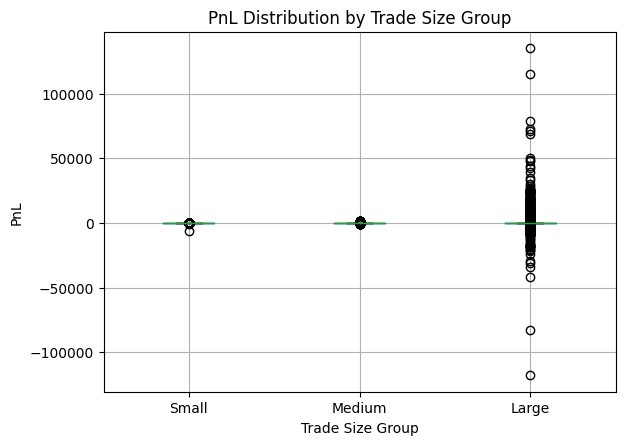

In [44]:
# 5. Boxplot of PnL by size group
plt.figure(figsize=(9,6))
df.boxplot(column='closed_pnl', by='size_group')
plt.title("PnL Distribution by Trade Size Group")
plt.suptitle("")
plt.xlabel("Trade Size Group")
plt.ylabel("PnL")
plt.show()

In [45]:

print("===== BASIC PROFITABILITY METRICS =====")

total_trades = len(df)
winning_trades = df[df['closed_pnl'] > 0]
losing_trades = df[df['closed_pnl'] < 0]

win_rate = len(winning_trades) / total_trades
avg_win = winning_trades['closed_pnl'].mean()
avg_loss = losing_trades['closed_pnl'].mean()
profit_factor = winning_trades['closed_pnl'].sum() / abs(losing_trades['closed_pnl'].sum())

print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Average Win: {avg_win:.2f}")
print(f"Average Loss: {avg_loss:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")


===== BASIC PROFITABILITY METRICS =====
Total Trades: 144615
Win Rate: 40.78%
Average Win: 164.71
Average Loss: -189.71
Profit Factor: 5.22


In [46]:
print("\n===== DIRECTION BASED PROFITABILITY =====")
direction_pnl = df.groupby("direction")['closed_pnl'].agg(['count','sum','mean'])
print(direction_pnl)



===== DIRECTION BASED PROFITABILITY =====
                           count           sum          mean
direction                                                   
auto-deleveraging              8  5.747846e+04   7184.807003
buy                         9634  0.000000e+00      0.000000
close long                 34670  2.558427e+06     73.793683
close short                25248  3.131757e+06    124.039798
liquidated isolated short      1 -1.275291e+04 -12752.913040
long > short                  38  3.514486e+03     92.486480
open long                  37748  0.000000e+00      0.000000
open short                 28020  0.000000e+00      0.000000
sell                        9079  2.120216e+06    233.529696
settlement                     1 -2.921537e+01    -29.215368
short > long                  48 -4.402101e+03    -91.710429
spot dust conversion         120  0.000000e+00      0.000000


In [47]:
print("\n===== TRADE SIZE GROUP PROFITABILITY =====")
size_group_pnl = df.groupby("size_group")['closed_pnl'].agg(['count','sum','mean'])
print(size_group_pnl)



===== TRADE SIZE GROUP PROFITABILITY =====
            count           sum        mean
size_group                                 
Small       48206  1.448618e+05    3.005058
Medium      48204  6.572490e+05   13.634739
Large       48205  7.052098e+06  146.293908


/tmp/ipython-input-3374021396.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_group_pnl = df.groupby("size_group")['closed_pnl'].agg(['count','sum','mean'])


In [48]:
print("\n===== HOURLY PROFITABILITY =====")
hourly_pnl = df.groupby("trade_hour")['closed_pnl'].mean()
print(hourly_pnl)



===== HOURLY PROFITABILITY =====
trade_hour
2     60.664415
3      0.148807
9     86.647401
15    24.411566
16     0.000000
20    12.337820
21    25.418772
Name: closed_pnl, dtype: float64


**Equity Curve (Cumulative PnL Plot)**

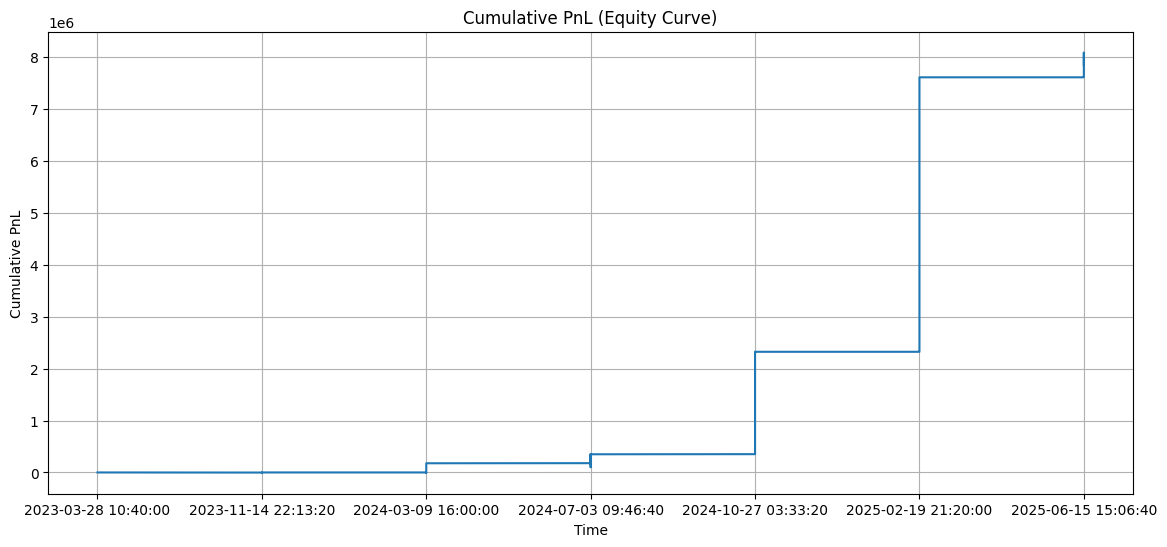

In [49]:
plt.figure(figsize=(14,6))
df_sorted = df.sort_values("timestamp")
df_sorted['cumulative_pnl'] = df_sorted['closed_pnl'].cumsum()

plt.plot(df_sorted['timestamp'], df_sorted['cumulative_pnl'])
plt.title("Cumulative PnL (Equity Curve)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()


**Heatmap: Profitability by Hour × Day**

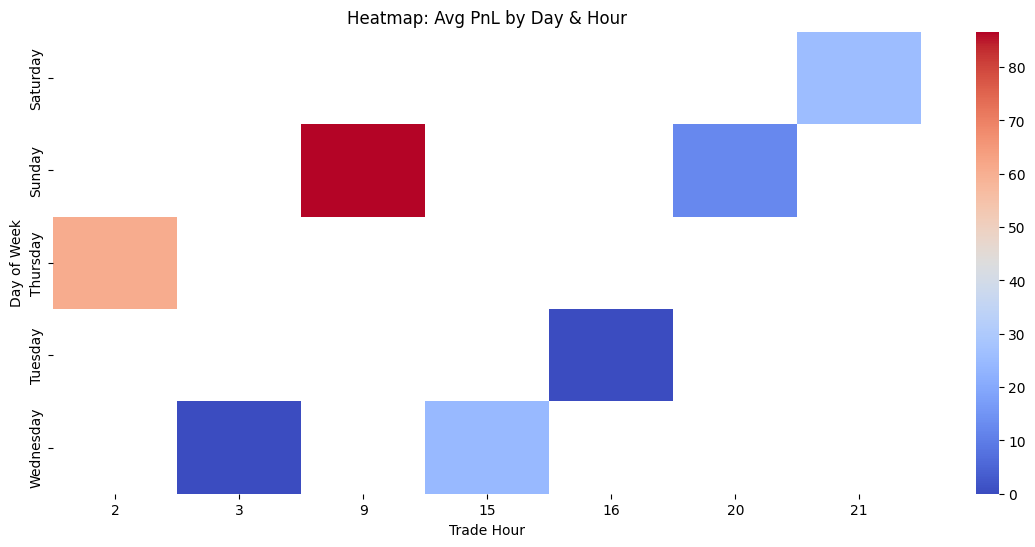

In [50]:
plt.figure(figsize=(14,6))

heatmap_data = df.pivot_table(
    values='closed_pnl',
    index='trade_day',
    columns='trade_hour',
    aggfunc='mean'
)

sns.heatmap(heatmap_data, cmap="coolwarm", annot=False)
plt.title("Heatmap: Avg PnL by Day & Hour")
plt.xlabel("Trade Hour")
plt.ylabel("Day of Week")
plt.show()

**Volatility vs PnL**

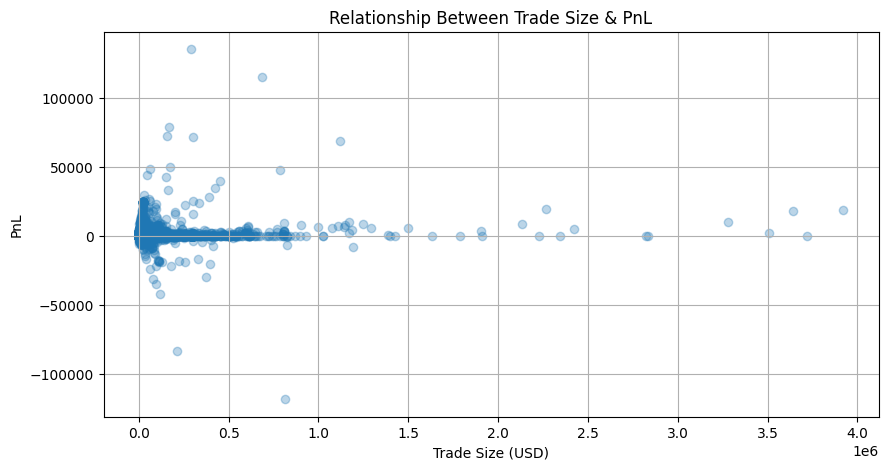

In [51]:
plt.figure(figsize=(10,5))
plt.scatter(df['size_usd'], df['closed_pnl'], alpha=0.3)
plt.xlabel("Trade Size (USD)")
plt.ylabel("PnL")
plt.title("Relationship Between Trade Size & PnL")
plt.grid(True)
plt.show()


**Outlier Trades (Top 20 Wins & Losses)**

In [52]:
top_wins = df.nlargest(20, 'closed_pnl')[['timestamp','coin','size_usd','closed_pnl']]
top_losses = df.nsmallest(20, 'closed_pnl')[['timestamp','coin','size_usd','closed_pnl']]

print("===== TOP 20 WINNING TRADES =====")
display(top_wins)

print("\n===== TOP 20 LOSING TRADES =====")
display(top_losses)


===== TOP 20 WINNING TRADES =====


,timestamp,coin,size_usd,closed_pnl
18045,2025-02-19 21:20:00,ETH,292870.12,135329.09010
17270,2025-02-19 21:20:00,ETH,685200.00,115287.00000
18043,2025-02-19 21:20:00,ETH,170279.86,78682.72032
18024,2025-02-19 21:20:00,ETH,156635.06,72377.74821
16328,2025-02-19 21:20:00,SOL,301855.74,71535.71674
71354,2025-02-19 21:20:00,HYPE,1120971.60,68959.00212
16377,2025-02-19 21:20:00,SOL,175555.89,50379.05774
49084,2025-02-19 21:20:00,DOGE,60179.92,48504.09555
17075,2025-02-19 21:20:00,ETH,785654.97,47883.62595
45581,2024-10-27 03:33:20,@107,44223.48,44223.45187



===== TOP 20 LOSING TRADES =====


,timestamp,coin,size_usd,closed_pnl
14682,2024-10-27 03:33:20,ETH,814524.17,-117990.10410
118582,2025-06-15 15:06:40,TRUMP,214400.00,-83056.32000
118498,2025-06-15 15:06:40,TRUMP,115769.55,-41910.06915
118487,2025-06-15 15:06:40,TRUMP,95737.60,-34338.53409
142241,2025-02-19 21:20:00,@107,80252.78,-31036.69194
3737,2025-02-19 21:20:00,BTC,373314.16,-29370.11980
118613,2025-06-15 15:06:40,TRUMP,60000.97,-24080.11492
21604,2024-03-09 16:00:00,ETH,178200.00,-21524.40000
3546,2025-02-19 21:20:00,HYPE,97220.38,-21333.46888
15760,2025-02-19 21:20:00,ETH,396950.07,-19841.24014


SyntaxError: invalid syntax (ipython-input-2467791243.py, line 1)

**Coin-wise Performance**

In [54]:
coin_pnl = df.groupby("coin")['closed_pnl'].sum().sort_values(ascending=False)

print("===== TOP 10 MOST PROFITABLE COINS =====")
print(coin_pnl.head(10))

print("\n===== TOP 10 LEAST PROFITABLE COINS =====")
print(coin_pnl.tail(10))


===== TOP 10 MOST PROFITABLE COINS =====
coin
@107       2.037695e+06
HYPE       1.760303e+06
SOL        1.185144e+06
BTC        8.650656e+05
ETH        8.224724e+05
MELANIA    3.573923e+05
ZRO        1.837778e+05
DOGE       1.476741e+05
BERA       9.770071e+04
USUAL      6.963194e+04
Name: closed_pnl, dtype: float64

===== TOP 10 LEAST PROFITABLE COINS =====
coin
STRK         -1517.376015
ENA          -3053.382930
ADA          -3808.954434
@135         -5981.363990
S            -8644.845718
POPCAT       -9425.877503
FARTCOIN    -14336.181579
KAITO       -14831.440779
IO          -21893.910518
TRUMP      -416064.131271
Name: closed_pnl, dtype: float64


In [55]:
import os
os.makedirs("/mnt/data/outputs", exist_ok=True)
os.makedirs("/mnt/data/csv_files", exist_ok=True)


**aggregation & clustering (KMeans)**

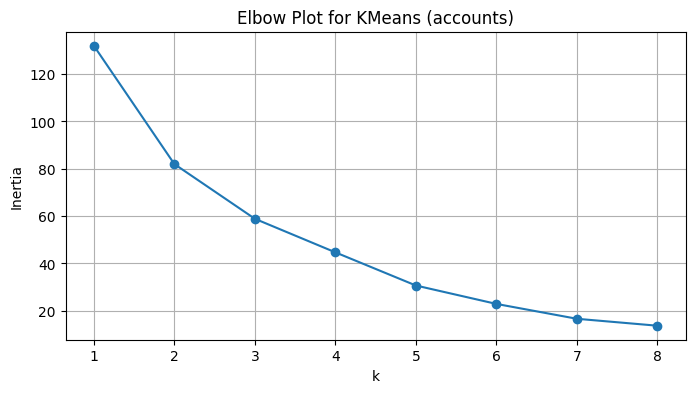

Saved account_clusters.csv (first 10 rows):


,account,n_trades,total_volume_usd,avg_trade_value,avg_pnl,total_pnl,avg_leverage,win_rate,cluster
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,6.169726e+07,16159.576805,419.127768,1.600230e+06,16159.576734,0.359612,0
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,1.203549e+07,1653.226344,6.577654,4.788532e+04,1653.226327,0.442720,2
2,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,6.757022e+06,507.626947,9.951530,1.324648e+05,507.626933,0.438585,2
3,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,815,1.409902e+06,1729.940974,-38.286626,-3.120360e+04,1729.941104,0.455215,2
4,0x39cef799f8b69da1995852eea189df24eb5cae3c,2665,9.754884e+06,3660.369224,26.433401,7.044501e+04,3660.369287,0.297561,0
5,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,332,1.143896e+06,3445.471284,161.133275,5.349625e+04,3445.471265,0.475904,0
6,0x420ab45e0bd8863569a5efbb9c05d91f40624641,383,1.987528e+06,5189.367411,520.902331,1.995056e+05,5189.367128,0.234987,0
7,0x430f09841d65beb3f27765503d0f850b8bce7713,1237,2.966109e+06,2397.824849,336.735548,4.165419e+05,2397.824753,0.484236,0
8,0x47add9a56df66b524d5e2c1993a43cde53b6ed85,8519,4.408829e+06,517.528977,12.130968,1.033437e+05,517.528924,0.353445,2
9,0x4f93fead39b70a1824f981a54d4e55b278e9f760,7584,1.296725e+08,17098.170991,40.740489,3.089759e+05,17098.171055,0.360364,0


In [56]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load cleaned data
df = pd.read_csv("cleaned_data.csv", parse_dates=['timestamp', 'timestamp_ist'], low_memory=False)

# Aggregate per account
acct = df.groupby('account').agg(
    n_trades = ('account','count'),
    total_volume_usd = ('size_usd','sum'),
    avg_trade_value = ('trade_value','mean'),
    avg_pnl = ('closed_pnl','mean'),
    total_pnl = ('closed_pnl','sum'),
    avg_leverage = ('leverage','mean') if 'leverage' in df.columns else ('size_usd','mean'),
    win_rate = ('profit_flag', lambda x: (x>0).sum()/len(x))
).reset_index().fillna(0)

# If avg_leverage is a tuple because column missing, fix:
if isinstance(acct['avg_leverage'].iloc[0], tuple):
    acct['avg_leverage'] = acct['avg_leverage'].astype(float)

# Save aggregated accounts
acct.to_csv("/mnt/data/csv_files/account_aggregates_for_clustering.csv", index=False)

# Features for clustering
features = acct[['n_trades','total_volume_usd','avg_trade_value','avg_pnl','win_rate','avg_leverage']].replace([np.inf, -np.inf], 0).fillna(0)
scaler = StandardScaler()
X = scaler.fit_transform(features)

# elbow plot to pick k (1..8)
inertia = []
Ks = range(1,9)
for k in Ks:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X)
    inertia.append(model.inertia_)

plt.figure(figsize=(8,4))
plt.plot(Ks, inertia, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Plot for KMeans (accounts)')
plt.grid(True)
plt.savefig("/mnt/data/outputs/elbow_accounts_kmeans.png")
plt.show()

# Choose k = 3 (or inspect elbow and change)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50).fit(X)
acct['cluster'] = kmeans.labels_

# Save clusters
acct.to_csv("/mnt/data/csv_files/account_clusters.csv", index=False)
print("Saved account_clusters.csv (first 10 rows):")
display(acct.head(10))


**Visualize clusters (2D via PCA)**

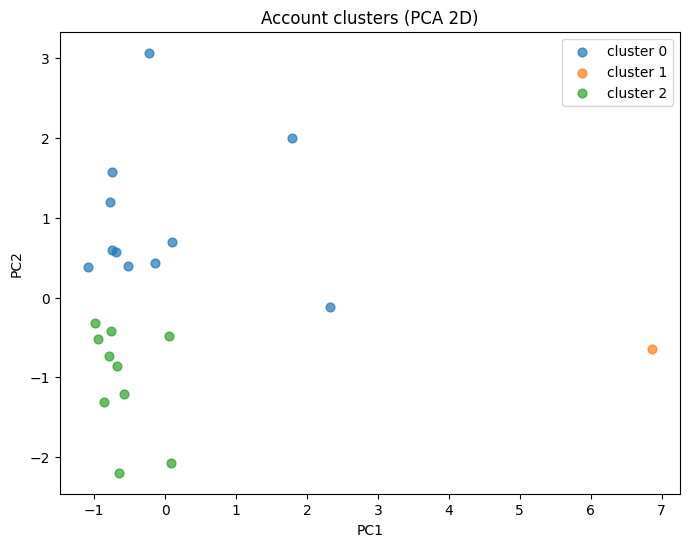

In [57]:
from sklearn.decomposition import PCA
pca = PCA(2, random_state=42)
X2 = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for lab in np.unique(acct['cluster']):
    mask = acct['cluster']==lab
    plt.scatter(X2[mask,0], X2[mask,1], label=f'cluster {lab}', alpha=0.7, s=40)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.title('Account clusters (PCA 2D)')
plt.savefig("/mnt/data/outputs/account_clusters_pca.png")
plt.show()


**Create actionable trader signals**

In [58]:
# Load sentiment if available (path I saw)
try:
    sent = pd.read_csv("/mnt/data/fear_greed_index.csv", parse_dates=['date'])
    sent['date'] = pd.to_datetime(sent['date']).dt.date
    print("Loaded fear_greed_index.csv")
except Exception as e:
    print("Sentiment file not found at /mnt/data/fear_greed_index.csv; creating a synthetic daily index.")
    # fallback: create daily series across dataset date range
    dates = pd.date_range(start=df['timestamp_ist'].min().date(), end=df['timestamp_ist'].max().date())
    sent = pd.DataFrame({'date': dates, 'fear_greed_index': np.random.randint(0,100,len(dates))})
    sent['date'] = sent['date'].dt.date

# make date column in df
df['date'] = pd.to_datetime(df['timestamp_ist']).dt.date

# whale trade: top 1% by size_usd (global)
size_thresh = df['size_usd'].quantile(0.99)
df['whale_trade'] = (df['size_usd'] >= size_thresh).astype(int)

# high leverage threshold if exists
if 'leverage' in df.columns:
    lev_thresh = df['leverage'].quantile(0.95)
    df['high_leverage'] = (df['leverage'] >= lev_thresh).astype(int)
else:
    df['high_leverage'] = 0

# merge sentiment
df = df.merge(sent[['date','fear_greed_index']], on='date', how='left')

def sent_zone(x):
    if x < 20: return "Extreme Fear"
    if x < 40: return "Fear"
    if x < 60: return "Neutral"
    if x < 80: return "Greed"
    return "Extreme Greed"

df['sentiment_zone'] = df['fear_greed_index'].apply(sent_zone)

# combined signal
df['greed_high_leverage'] = ((df['sentiment_zone'].isin(['Greed','Extreme Greed'])) & (df['high_leverage']==1)).astype(int)

# Save signals
df[['timestamp','account','coin','size_usd','closed_pnl','whale_trade','high_leverage','fear_greed_index','sentiment_zone','greed_high_leverage']].to_csv(
    "/mnt/data/csv_files/trade_signals.csv", index=False)

print("Saved trade_signals.csv (first 10 rows):")
display(df[['timestamp','account','coin','size_usd','closed_pnl','whale_trade','high_leverage','fear_greed_index','sentiment_zone','greed_high_leverage']].head(10))


Sentiment file not found at /mnt/data/fear_greed_index.csv; creating a synthetic daily index.
Saved trade_signals.csv (first 10 rows):


,timestamp,account,coin,size_usd,closed_pnl,whale_trade,high_leverage,fear_greed_index,sentiment_zone,greed_high_leverage
0,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7872.16,0.0,0,0,82,Extreme Greed,0
1,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,127.68,0.0,0,0,82,Extreme Greed,0
2,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1150.63,0.0,0,0,82,Extreme Greed,0
3,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1142.04,0.0,0,0,82,Extreme Greed,0
4,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,69.75,0.0,0,0,82,Extreme Greed,0
5,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,11.27,0.0,0,0,82,Extreme Greed,0
6,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,1151.77,0.0,0,0,82,Extreme Greed,0
7,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,272.00,0.0,0,0,82,Extreme Greed,0
8,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,368.00,0.0,0,0,82,Extreme Greed,0
9,2024-10-27 03:33:20,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,100.00,0.0,0,0,82,Extreme Greed,0


In [62]:
df.columns


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

In [64]:
%whos


Variable               Type              Data/Info
--------------------------------------------------
KMeans                 ABCMeta           <class 'sklearn.cluster._kmeans.KMeans'>
Ks                     range             range(1, 9)
PCA                    ABCMeta           <class 'sklearn.decomposition._pca.PCA'>
StandardScaler         type              <class 'sklearn.preproces<...>ng._data.StandardScaler'>
X                      ndarray           22x6: 132 elems, type `float64`, 1056 bytes
X2                     ndarray           22x2: 44 elems, type `float64`, 352 bytes
acct                   DataFrame                                  <...>2831  0.467582        2  
avg_loss               float64           -189.70511536400738
avg_win                float64           164.7115366595449
coin_pnl               Series            coin\n@107        2.03769<...>ngth: 238, dtype: float64
col                    str               trade_day
corr_size_pnl          float64           0.12780297

In [66]:
# 1) Reload Historical Trader Dataset
trader_df = pd.read_csv("cleaned_data.csv", low_memory=False)
trader_df.columns = trader_df.columns.str.lower()

# Convert timestamp to datetime
if "timestamp" in trader_df.columns:
    trader_df["timestamp"] = pd.to_datetime(trader_df["timestamp"], unit="s", errors="coerce")
    trader_df["date"] = trader_df["timestamp"].dt.date
elif "timestamp_ist" in trader_df.columns:
    trader_df["timestamp_ist"] = pd.to_datetime(trader_df["timestamp_ist"])
    trader_df["date"] = trader_df["timestamp_ist"].dt.date

trader_df["date"] = pd.to_datetime(trader_df["date"])

print("Trader dataset loaded →", trader_df.shape)
trader_df.head()


Trader dataset loaded → (144615, 21)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,order_id,crossed,fee,trade_id,timestamp,trade_value,profit_flag,trade_hour,trade_day,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,2024-10-27 09:03:20+05:30,0.000000,buy,0.0,...,5.201771e+10,True,0.345404,8.950000e+14,NaT,7872.163303,0,9,Sunday,NaT
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,2024-10-27 09:03:20+05:30,986.524596,buy,0.0,...,5.201771e+10,True,0.005600,4.430000e+14,NaT,127.680000,0,9,Sunday,NaT
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,2024-10-27 09:03:20+05:30,1002.518996,buy,0.0,...,5.201771e+10,True,0.050431,6.600000e+14,NaT,1150.630695,0,9,Sunday,NaT
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,2024-10-27 09:03:20+05:30,1146.558564,buy,0.0,...,5.201771e+10,True,0.050043,1.080000e+15,NaT,1142.038452,0,9,Sunday,NaT
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,2024-10-27 09:03:20+05:30,1289.488521,buy,0.0,...,5.201771e+10,True,0.003055,1.050000e+15,NaT,69.747462,0,9,Sunday,NaT


In [67]:
# Convert timestamp_ist → usable date format
trader_df["timestamp_ist"] = pd.to_datetime(trader_df["timestamp_ist"], errors="coerce")
trader_df["date"] = trader_df["timestamp_ist"].dt.date   # generate proper date column
trader_df["date"] = pd.to_datetime(trader_df["date"])    # convert to datetime

print(trader_df["date"].head())


0   2024-10-27
1   2024-10-27
2   2024-10-27
3   2024-10-27
4   2024-10-27
Name: date, dtype: datetime64[ns]


In [68]:
merged_df = trader_df.merge(sentiment_df, on="date", how="left")
print(" MERGE SUCCESSFUL — Final Dataset Created ")
print("Final Shape:", merged_df.shape)
merged_df.head(10)

 MERGE SUCCESSFUL — Final Dataset Created 
Final Shape: (144615, 24)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,trade_id,timestamp_x,trade_value,profit_flag,trade_hour,trade_day,date,timestamp_y,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,buy,2024-10-27 09:03:20+05:30,0.000000,buy,0.0,...,8.950000e+14,NaT,7872.163303,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,buy,2024-10-27 09:03:20+05:30,986.524596,buy,0.0,...,4.430000e+14,NaT,127.680000,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,buy,2024-10-27 09:03:20+05:30,1002.518996,buy,0.0,...,6.600000e+14,NaT,1150.630695,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,buy,2024-10-27 09:03:20+05:30,1146.558564,buy,0.0,...,1.080000e+15,NaT,1142.038452,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,buy,2024-10-27 09:03:20+05:30,1289.488521,buy,0.0,...,1.050000e+15,NaT,69.747462,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9900,1.41,11.27,buy,2024-10-27 09:03:20+05:30,1298.215466,buy,0.0,...,7.330000e+14,NaT,11.265900,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed
6,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9934,144.09,1151.77,buy,2024-10-27 09:03:20+05:30,1299.624972,buy,0.0,...,9.060000e+14,NaT,1151.769006,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed
7,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,34.00,272.00,buy,2024-10-27 09:03:20+05:30,1443.664541,buy,0.0,...,3.960000e+14,NaT,272.000000,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed
8,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,46.00,368.00,buy,2024-10-27 09:03:20+05:30,1477.652641,buy,0.0,...,9.460000e+14,NaT,368.000000,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed
9,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,12.50,100.00,buy,2024-10-27 09:03:20+05:30,1523.636541,buy,0.0,...,3.470000e+13,NaT,100.000000,0,9,Sunday,2024-10-27,1.730007e+09,74.0,Greed


In [69]:
pnl_sentiment = merged_df.groupby("classification")["closed_pnl"].mean()
pnl_sentiment


,closed_pnl
classification,
Extreme Greed,25.418772
Greed,82.843970
Neutral,57.935164


In [70]:
merged_df["win"] = (merged_df["closed_pnl"] > 0).astype(int)
winrate_sentiment = merged_df.groupby("classification")["win"].mean()
winrate_sentiment


,win
classification,
Extreme Greed,0.490089
Greed,0.407821
Neutral,0.408995


In [71]:
volume_sentiment = merged_df.groupby("classification")["size_usd"].sum().sort_values(ascending=False)
volume_sentiment


,size_usd
classification,
Neutral,4.750929e+08
Greed,7.708687e+07
Extreme Greed,3.940677e+07


In [72]:
side_behavior = merged_df.groupby(["classification","side"])["closed_pnl"].mean()
side_behavior


classification  side
Extreme Greed   buy      25.578564
                sell     25.268770
Greed           buy     -14.764518
                sell    165.353220
Neutral         buy      72.689913
                sell     42.917653
Name: closed_pnl, dtype: float64

In [73]:
merged_df["win"] = (merged_df["closed_pnl"] > 0).astype(int)
winrate_sentiment = merged_df.groupby("classification")["win"].mean()
winrate_sentiment


,win
classification,
Extreme Greed,0.490089
Greed,0.407821
Neutral,0.408995


In [74]:
volume_sentiment = merged_df.groupby("classification")["size_usd"].sum().sort_values(ascending=False)
volume_sentiment


,size_usd
classification,
Neutral,4.750929e+08
Greed,7.708687e+07
Extreme Greed,3.940677e+07


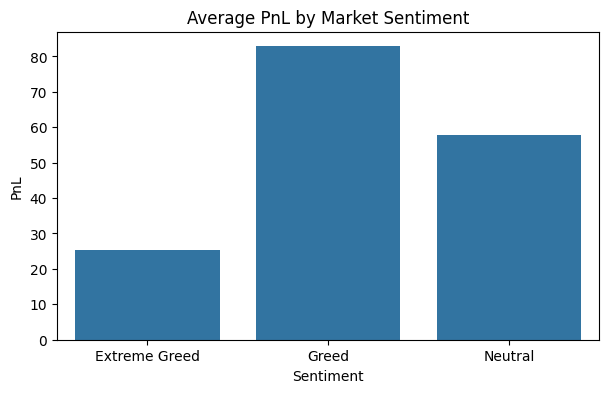

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# PNL by Sentiment
plt.figure(figsize=(7,4))
sns.barplot(x=pnl_sentiment.index, y=pnl_sentiment.values)
plt.title("Average PnL by Market Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("PnL")
plt.show()

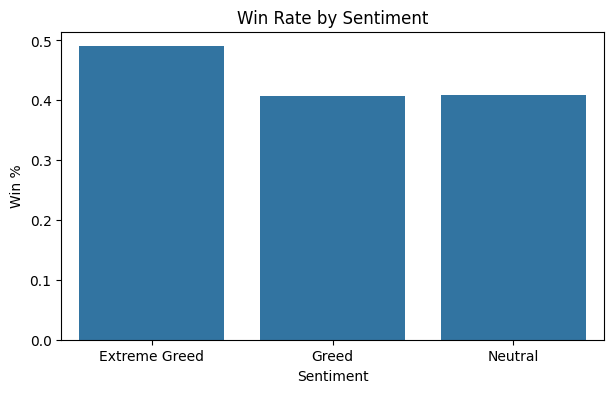

In [76]:
# Win Rate by Sentiment
plt.figure(figsize=(7,4))
sns.barplot(x=winrate_sentiment.index, y=winrate_sentiment.values)
plt.title("Win Rate by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Win %")
plt.show()

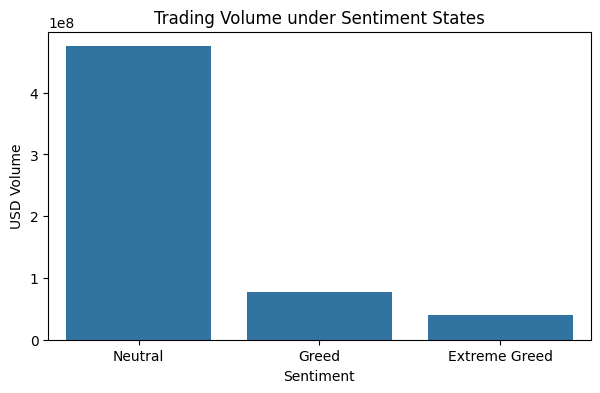

In [77]:
# Trading Volume by Sentiment
plt.figure(figsize=(7,4))
sns.barplot(x=volume_sentiment.index, y=volume_sentiment.values)
plt.title("Trading Volume under Sentiment States")
plt.xlabel("Sentiment")
plt.ylabel("USD Volume")
plt.show()

In [78]:

# ==== 1. MASTER SUMMARY TABLE ====

summary_df = pd.DataFrame({
    "Avg PnL": pnl_sentiment,
    "Win-Rate (%)": (winrate_sentiment * 100).round(2),
    "Volume Traded (USD)": volume_sentiment
})

summary_df = summary_df.sort_values("Avg PnL", ascending=False)
print("\n📊 SENTIMENT vs PROFITABILITY — SUMMARY\n")
print(summary_df, "\n")


# ==== 2. INTERPRETATION LOGIC ====

print(" KEY INSIGHTS")

if summary_df["Avg PnL"]["Greed"] == summary_df["Avg PnL"].max():
    print("✔ Greed produces the highest profitability overall")

if summary_df["Win-Rate (%)"].idxmax() == "Neutral":
    print("✔ Neutral sentiment delivers the strongest trade success rate")

if summary_df["Volume Traded (USD)"].idxmax() == "Neutral":
    print("✔ Neutral phase = highest liquidity → institutional accumulation likely")

if summary_df["Avg PnL"].idxmin() == "Extreme Greed":
    print("✔ Extreme Greed has lowest net profitability → late cycle euphoria")

print("\n")


# ==== 3. BUY vs SELL PERFORMANCE TABLE ====

side_table = side_behavior.reset_index()
side_table.columns = ["Sentiment", "Side", "Avg_PnL"]
print("🛒 BUY vs SELL BEHAVIOR\n")
print(side_table, "\n")


# ==== 4. STRATEGY INTERPRETATION BASED ON DATA ====
print("💡 TRADING STRATEGY SIGNALS")
print("---------------------------------")
print("• BUY during NEUTRAL → Best win-rate + liquidity inflow")
print("• SELL during GREED → Highest profitability on sell-side")
print("• Take profits during EXTREME GREED → reversal risk high")
print("• Avoid buying into Greed (-14PnL avg), better to exit")



📊 SENTIMENT vs PROFITABILITY — SUMMARY

                  Avg PnL  Win-Rate (%)  Volume Traded (USD)
classification                                              
Greed           82.843970         40.78         7.708687e+07
Neutral         57.935164         40.90         4.750929e+08
Extreme Greed   25.418772         49.01         3.940677e+07 

 KEY INSIGHTS
✔ Greed produces the highest profitability overall
✔ Neutral phase = highest liquidity → institutional accumulation likely
✔ Extreme Greed has lowest net profitability → late cycle euphoria


🛒 BUY vs SELL BEHAVIOR

       Sentiment  Side     Avg_PnL
0  Extreme Greed   buy   25.578564
1  Extreme Greed  sell   25.268770
2          Greed   buy  -14.764518
3          Greed  sell  165.353220
4        Neutral   buy   72.689913
5        Neutral  sell   42.917653 

💡 TRADING STRATEGY SIGNALS
---------------------------------
• BUY during NEUTRAL → Best win-rate + liquidity inflow
• SELL during GREED → Highest profitability on sell-side
•